In [8]:
import itertools
import numpy as np
import pycountry
import copy
from climada.util.constants import DEF_CRS
from climada.engine import Impact, ImpactCalc

from climada.util import coordinates
from climada.engine import Impact

def impact_select_country(impact, country):
    """
    Create a new impact object containing only the data for a specified country.

    This function filters an existing impact object to include only the data points
    that are within the boundaries of a given country. The function uses latitude and 
    longitude coordinates from the 'impact' object to determine the country of each 
    data point. It then filters the impact matrix and coordinates to include only those
    corresponding to the specified country.

    The country is specified by its ISO 3166-1 numeric code as a three-digit string. 
    For example, '840' for the United States, '124' for Canada, and '392' for Japan.

    Parameters:
    ----------
    impact : Impact
        The impact object to be filtered. This object should contain latitude and 
        longitude coordinates ('coord_exp') and an impact matrix ('imp_mat').

    country : str
        The three-digit string representing the ISO 3166-1 numeric country code.

    Returns:
    -------
    Impact
        A new Impact object containing only the data for the specified country.
    """
    lat, lon = np.array(impact.coord_exp).T
    countries_num = coordinates.get_country_code(lat, lon)
    countries_num = np.array([format(num, '03d') for num in countries_num])
    imp_mat = impact.imp_mat[:, countries_num == str(country)]
    coord_exp = impact.coord_exp[countries_num == str(country)]
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, impact.frequency)
    
    impact_country = Impact(
        event_id=impact.event_id,
        event_name=impact.event_name,
        date=impact.date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=impact.frequency,
        unit=impact.unit,
        frequency_unit=impact.unit,
    )
    return impact_country


def aggregate_impact_by_date(impact, how='sum', exp=None):
    """
    Aggregate events to have lower resolution. Maximum impact per year
    at each exposure point is exposure value if exp is not None.

    Parameters
    ----------
    impact : Impact
        Impact with an impact matrix and events with dates per year
    how : How to aggregate impacts, options are 'sum' or 'max'
    exp : Exposure
        Exposure of Impact to cap the impact value at the value of the exposure

    Raises
    ------
    AttributeError
        If impact matrix is empty.

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_upscaled_dates = copy.deepcopy(impact)
    if how == 'sum':
        mask = [np.ma.make_mask(np.array(impact_upscaled_dates.date) == event).astype(int)
                for event in np.unique(impact_upscaled_dates.date)]
        mask_matrix = sp.sparse.csr_matrix(mask)
        imp_mat = mask_matrix.dot(impact_upscaled_dates.imp_mat)

    elif how == 'max':
        imp_mat = sp.sparse.csr_matrix(sp.sparse.vstack(
            [impact_upscaled_dates.imp_mat[(np.array(impact_upscaled_dates.date) == date).astype(bool)].max(axis=0)
             for date in np.unique(impact_upscaled_dates.date)]))
    else:
        warnings.warn("Unsupported value for 'how' parameter. Only 'sum' and 'max' methods are currently supported.")

    if exp is not None:
        m1 = imp_mat.data
        m2 = np.array(exp.gdf.value[imp_mat.nonzero()[1]])
        imp_mat = sp.sparse.csr_matrix((np.minimum(m1, m2), imp_mat.indices, imp_mat.indptr))

    years = np.unique([datetime.date.fromordinal(int(date)) for date in impact.date])
    frequency = np.ones(imp_mat.shape[0]) / len(np.unique(years))
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)
    date = np.unique(impact_upscaled_dates.date)
    event_id = np.arange(1, len(at_event) + 1)
    event_name = np.unique(event_id)
    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=impact.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=impact.frequency,
        tot_value=5,
        unit="USD",
        frequency_unit="1/year"
    )
    return impact_aggr


def combine_impacts(impact_list, how='sum', by='date', exp=None):
    """
    Parameters
    ----------
    impact_list : list or dict of impacts with the same coord and dates
    how : how to combine the impacts, options are 'sum', 'max' or 'min'
    by : array of common value used to combine events, can be date, event_id or event_name
    exp : If the exposures are given, the impacts are caped at their value

    Returns
    -------
    imp : Impact
        Combined impact
    """
    if isinstance(impact_list, dict):
        impact_list = list(impact_list.values())

    imp0 = copy.deepcopy(impact_list[0])
    for imp in impact_list:
        if imp.unit != imp0.unit:
            raise ValueError("The impacts do not have the same units and cannot be combined.")
        # Check if imp_mat contains non-zero values
        if imp.imp_mat.nnz == 0:
            raise ValueError("imp_mat contains only zero values")

        # Check if all imp_mat are of the same shape
        if np.any(imp.date != imp0.date) and by=='date':
            raise ValueError("All impacts must have the same dates to be combined by date. Use the method fill_impact_gaps"
                             "first.")
        if np.any(imp.event_name != imp0.event_name) and by=='event_name':
            raise ValueError("All impacts must have the same event_name to be combined by event_name")

        if np.any(imp.event_id != imp0.event_id) and by == 'event_id':
            raise ValueError("All impacts must have the same event_id to be combined by event_id")

        if np.any(imp.coord_exp != imp0.coord_exp):
            raise ValueError("All impacts must have the same coordinates to be combined. Use the method fill_impact_gaps"
                             "first.")

        if imp.unit != imp0.unit:
            raise ValueError("All impacts must have the same units to be combined. If you want to assess events"
                             "affecting exposures with different unit, you may normalize the impact first.")

    if by == 'event_name' or by == 'date':
        aggr_attr = {'event_name': imp.event_name, 'date':imp.date}
        unique_elements = np.unique(aggr_attr[by])
        # Create a dictionary mapping unique elements to integers
        element_to_int = {element: i + 1 for i, element in enumerate(unique_elements)}

        # Map unique elements to integers using the dictionary
        imp.event_id = np.array([element_to_int[element] for element in aggr_attr[by]])
    elif by != 'event_id':
        raise NotImplementedError("This method is not implemented to combine impacts.")

    if how == 'sum':
        imp_mat_sum = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_sum = imp_mat_sum + imp.imp_mat
        imp_mat = imp_mat_sum

    elif how == 'min':
        imp_mat_min = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_min = imp_mat_min.minimum(imp.imp_mat)
        imp_mat = imp_mat_min

    elif how == 'max':
        imp_mat_max = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_max = imp_mat_max.maximum(imp.imp_mat)
        imp_mat = imp_mat_max
    else:
        raise ValueError(f"'{how}' is not a valid method. The implemented methods are sum, max or min")

    if exp is not None:
        m1 = imp_mat.data
        m2 = exp.gdf.value[imp_mat.nonzero()[1]]
        imp_mat = sp.sparse.csr_matrix((np.minimum(m1, m2), imp_mat.indices, imp_mat.indptr))
        imp_mat.eliminate_zeros()

    years = np.unique([datetime.date.fromordinal(int(date)).year for date in imp0.date])
    frequency = np.ones(imp_mat.shape[0]) / len(np.unique(years))
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)

    if np.all(imp.event_id == imp0.event_id and imp.event_name == imp0.event_name for imp in impact_list):
        event_id = imp0.event_id
        event_name = imp0.event_name
    else:
        event_id = np.arange(1, len(at_event) + 1)
        event_name = event_id

    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=imp0.date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=imp0.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=frequency,
        tot_value=5,
        unit=imp0.unit,
        frequency_unit="1/year",
    )
    return impact_aggr

def get_indices(impact, n_samples, list_string):
    """Return the indices of the event names ordered based on the given lists of strings."""

    n_samples = int(n_samples)

    indices = {str1: np.unique([i for i, elem in enumerate(impact.event_name) if
                      (str(str1) in elem)]) for str1 in list_string}

    indices = [np.random.choice(indices[str1]) for str1 in list_string for
               n in range(n_samples)]

    return indices


def order_events_by_indices(impact, indices):
    """
    Order event names based on given strings contained in the event names.

    Parameters
    ----------
    impact: Impact
        with event_name based on the given strings
    n_events: Int
        Number of events in the output. Default: 1
    list_string : list
        A list of string based on which to order the events.
        For example climate models ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
        default is None


    Raises
    ------
    AttributeError
        If no list is providing

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_ordered = copy.deepcopy(impact)
    impact_ordered.imp_mat = impact.imp_mat[indices]
    impact_ordered.event_name = [impact.event_name[index] for index in indices]
    impact_ordered.event_id = np.arange(len(impact_ordered.event_name))
    frequency = impact.frequency[indices]
    impact_ordered.frequency = frequency*(len(impact.event_id)/len(impact_ordered.event_id))
    impact_ordered.at_event = impact.at_event[indices]
    impact_ordered.date = impact.date[indices]
    return impact_ordered

In [2]:
from climada.engine import Impact
from pathlib import Path
import numpy as np
path_impacts = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/impacts/global/")

impacts_hw = {}
for warming_level in ['1', '2']:
    impacts_hw[warming_level] = Impact.from_csv(path_impacts / f"csvs_climada_v4/HW_impact_pop_150arcsec_{warming_level}_vnm.csv")
    impacts_hw[warming_level].imp_mat = Impact.read_sparse_csr(path_impacts / f"npz/HW_impact_pop_150arcsec_{warming_level}_vnm.npz")
    #impacts_hw[warming_level] = impact_select_country(impacts_hw[warming_level], 704)
    impacts_hw[warming_level].frequency = np.ones(len(impacts_hw[warming_level].frequency))/ len(impacts_hw[warming_level].frequency)

2023-12-01 11:32:02,745 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-12-01 11:32:02,954 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


In [15]:
impacts_hw['1'].at_event.mean()/1e6

10.786966194930491

In [9]:
import pandas as pd
import numpy as np
from climada.engine import Impact
from pathlib import Path
import itertools

In [10]:


# Constants
COUNTRIES = ['704']  # List of countries you are interested in
WARMING_LEVELS = ['1', '2']
HAZARDS = ['TC', 'RF']
EXPOSURES = ['pop']
DIR_IMPACTS_V4 = Path('/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/results_climada_v4.0/yearsets')
IMP_MAT_YEARSETS_DIR = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/yearsets/global/npz")

# Function to create file path for the yearsets
def create_yearsets_file_path(hazard, exposure, warming, country, is_caped, base_dir):
    caped_suffix = "_caped" if is_caped else ""
    file_name = f"{hazard}_{exposure}_impacts_yearsets_150arcsec_{warming}_global{caped_suffix}.csv"
    return base_dir / file_name

def load_and_process_impact_for_hazard(hazard, exposure, warming, country, is_caped):
    """
    Load data from CSV, load sparse matrix, and apply impact_select_country function.
    """
    # Load data from CSV
    csv_file_path = create_yearsets_file_path(hazard, exposure, warming, country, is_caped, DIR_IMPACTS_V4)
    impact_obj = Impact.from_csv(csv_file_path)

    # Load sparse matrix
    caped_suffix = "_caped" if is_caped else ""
    npz_file_name = f"{hazard}_{exposure}_impacts_yearsets_150arcsec_{warming}_global{caped_suffix}.npz"
    npz_file_path = IMP_MAT_YEARSETS_DIR / npz_file_name
    impact_obj.imp_mat = Impact.read_sparse_csr(npz_file_path)

    # Apply impact_select_country function
    return impact_select_country(impact_obj, country)

def load_impact_data_for_country(country, is_caped):
    """
    Load and process impact data for a specific country.
    """
    country_impacts = {}
    for warming in WARMING_LEVELS:
        country_impacts[warming] = {}
        for exposure in EXPOSURES:
            country_impacts[warming][exposure] = {}
            for hazard in HAZARDS:
                country_impacts[warming][exposure][hazard] = load_and_process_impact_for_hazard(hazard, exposure, warming, country, is_caped)
                country_impacts[warming][exposure][hazard].event_name = ["_".join(event.split("_")[0:3]) for event in country_impacts[warming][exposure][hazard].event_name]
    return country_impacts

# #Main processing loop for each country
# all_countries_impacts = {}
# for country in COUNTRIES:
#     is_caped = True  # or False, depending on your requirements
#     all_countries_impacts[country] = load_impact_data_for_country(country, is_caped)

# print("Yearsets datasets processed successfully for all countries.")


In [1]:
# impacts_country_path = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/countries")
# for country in COUNTRIES:
#     alpha_3 = pycountry.countries.get(numeric=country).alpha_3
#     for warming in ['1', '2']:
#         for exposure in EXPOSURES:
#             for hazard in HAZARDS:
#                 all_countries_impacts[country][warming]['pop'][hazard].write_csv(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.csv")
#                 all_countries_impacts[country][warming]['pop'][hazard].write_sparse_csr(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.npz")


In [11]:
import pycountry
COUNTRIES = ['704']  # List of countries you are interested in
WARMING_LEVELS = ['1', '2']
HAZARDS = ['TC', 'RF']
EXPOSURES = ['pop']
DIR_IMPACTS_V4 = Path('/nfs/n2o/wcr/szelie/impacts_multi_risk/results_climada_v4.0/yearsets')
IMP_MAT_YEARSETS_DIR = Path("/nfs/n2o/wcr/szelie/impacts_multi_risk/yearsets/global/npz")

all_countries_impacts = {}
impacts_country_path = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/countries")
for country in COUNTRIES:
    all_countries_impacts[country] = {}
    alpha_3 = pycountry.countries.get(numeric=country).alpha_3
    for warming in WARMING_LEVELS:
        all_countries_impacts[country][warming] = {}
        for exposure in EXPOSURES:
            all_countries_impacts[country][warming][exposure] = {}
            for hazard in HAZARDS:
                all_countries_impacts[country][warming][exposure][hazard] = Impact.from_csv(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.csv")
                all_countries_impacts[country][warming][exposure][hazard].imp_mat = Impact.read_sparse_csr(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.npz")


2023-12-01 11:32:27,384 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-12-01 11:32:27,637 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-12-01 11:32:27,762 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-12-01 11:32:27,981 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


In [6]:
len(set(all_countries_impacts[country][warming][exposure][hazard].event_name))

105

In [7]:
set(impacts_hw['2'].event_name) - set(all_countries_impacts[country]['2'][exposure][hazard].event_name)

set()

In [12]:
import numpy as np
import copy
impact_yearsets_hw = {}
for country in all_countries_impacts:
    alpha_3 = pycountry.countries.get(numeric=country).alpha_3
    for warming_level in ['1', '2']:
        for exposure in EXPOSURES:
            event_name = ["_".join(name.split("_")[0:3]) for name in all_countries_impacts[country][warming_level]['pop']['RF'].event_name]
            indices = get_indices(impacts_hw[warming_level], 1, event_name)
            all_countries_impacts[country][warming_level]['pop']['HS'] = order_events_by_indices(impacts_hw[warming_level], indices)
            all_countries_impacts[country][warming_level]['pop']['HS'].frequency = all_countries_impacts[country][warming_level]['pop']['RF'].frequency
            all_countries_impacts[country][warming_level]['pop']['HS'].event_id = all_countries_impacts[country][warming_level]['pop']['RF'].event_id

In [13]:
import datetime
combined_impact = combine_impacts(list(all_countries_impacts['704']['1']['pop'].values()),
                                  by="event_name", how="min")

In [14]:
import datetime
import numpy as np

HAZARDS = ['TC', 'RF', 'HS']

# Initialize a dictionary to store the combined impacts
combined_impacts_pairs = {}

# Define hazard pairs
HAZARD_PAIRS = [('TC', 'RF'), ('TC', 'HS'), ('RF', 'HS')]

# Loop through each country
for country in COUNTRIES:
    combined_impacts_pairs[country] = {}

    # Loop through each warming level
    for warming in ['1','2']:
        combined_impacts_pairs[country][warming] = {}

        # Loop through each exposure
        for exposure in EXPOSURES:
            combined_impacts_pairs[country][warming][exposure] = {}

            # Loop through each pair of hazards
            for hazard_pair in HAZARD_PAIRS:
                # Collect impact objects for this pair of hazards
                impacts_to_combine = [all_countries_impacts[country][warming][exposure][hazard] 
                                      for hazard in hazard_pair 
                                      if hazard in all_countries_impacts[country][warming][exposure]]

                # Check if both hazards in the pair are present
                if len(impacts_to_combine) == 2:
                    # Combine the impacts
                    combined_impact_pairs = combine_impacts(impacts_to_combine, by="event_name", how="min")

                    # Adjust the frequency
                    freq = combined_impact_pairs.frequency
                    combined_impact_pairs.frequency = np.ones(len(freq)) / len(freq)

                    # Store the combined impact under a key representing the pair
                    combined_impacts_pairs[country][warming][exposure][hazard_pair] = combined_impact_pairs
                    combined_impacts_pairs[country][warming][exposure][hazard_pair].event_id = np.arange(0,len(combined_impacts_pairs[country][warming][exposure][hazard_pair].frequency))

# Now `combined_impacts` dictionary has the combined impacts for each pair of hazards for each country, warming level, and exposure


In [15]:
import datetime

HAZARDS = ['TC','RF','HS']

# Initialize a dictionary to store the combined impacts
combined_impacts = {}

# Loop through each country
for country in COUNTRIES:
    combined_impacts[country] = {}

    # Loop through each warming level
    for warming in ['1', '2']:
        combined_impacts[country][warming] = {}

        # Loop through each exposure
        for exposure in EXPOSURES:
            # Collect all impact objects for this country, warming level, and exposure
            impacts_to_combine = [all_countries_impacts[country][warming][exposure][hazard] 
                                  for hazard in HAZARDS if hazard in all_countries_impacts[country][warming][exposure]]

            # Combine the impacts
            combined_impact = combine_impacts(impacts_to_combine, by="event_name", how="min")

            # Store the combined impact
            combined_impacts[country][warming][exposure] = combined_impact
            freq =combined_impacts[country][warming][exposure].frequency
            combined_impacts[country][warming][exposure].frequency = np.ones(len(freq))/len(freq)
            combined_impacts[country][warming][exposure].event_id = np.arange(0,len(combined_impacts[country][warming][exposure].frequency))

# Now `combined_impacts` dictionary has the combined impacts for each country, warming level, and exposure


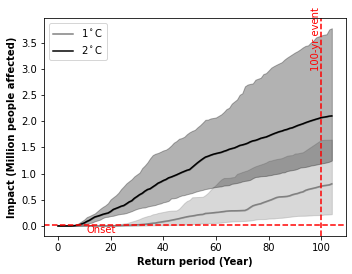

In [19]:

import copy
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
ylabel = {"assets":"Impact (Billion USD)","pop":"Impact (Million people affected)"}
country = '704'
plt.rcParams['axes.labelweight'] = 'bold'

fq = all_countries_impacts[country]['1']['pop']['RF'].calc_freq_curve(return_per=np.arange(1,105))
def make_fq_list(impact, factor):
    fq_list = []
    for n in range(1000):
        imp_sample = order_events_by_indices(impact, shuffle(np.arange(len(impact.event_name)))[0:500])
        fq = imp_sample.calc_freq_curve(np.arange(0,105))
        fq_list.append(fq.impact/factor)
    return fq_list, fq.return_per

def plot_return_period_samples(fq_list, return_per, ax, color, label, range=True, linestyle="solid", linewidth=1.5):
    ax.plot(fq.return_per,np.median(fq_list,axis=0), color=color, label=label, linestyle=linestyle,linewidth=linewidth)
    ax.legend()
    if range:
        ax.fill_between(fq.return_per,np.median(fq_list,axis=0),np.percentile(fq_list,q=95,axis=0), color=color, alpha=0.3)
        ax.fill_between(fq.return_per,np.percentile(fq_list,q=5,axis=0), np.median(fq_list,axis=0),color=color, alpha=0.3)
    return ax

factor_dict = {"assets":1e9, "pop":1e6}

fig,ax = plt.subplots(figsize=(5.4,4))
fq_list_dict = {}
colors = {"1":"gray","2":"black"}
for exposure in ["pop"]:
    for period in ["1", "2"]:
        #yearsets_sum = copy.deepcopy(impacts_yearsets[period][exposure]['RF'])
        #yearsets_sum.at_event = impacts_yearsets[period][exposure]['RF'].at_event + shuffle(impacts_yearsets[period][exposure]['TC'].at_event)
        fq_list_rf, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['RF'], factor=factor_dict[exposure])
        fq_list_tc, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['TC'], factor=factor_dict[exposure])
    
        fq_list_dict[period], fq.return_per =  make_fq_list(combined_impacts[country][period][exposure], factor=factor_dict[exposure])

        
        ax = plot_return_period_samples( fq_list_dict[period], fq.return_per, ax, color=colors[period], label="".join([period,"$^\circ$C"]), range=True)
#        # plot_return_period_samples(fq_list, fq.return_per, ax, color="black", linestyle='dashed', label="Aggregated", range=True, linewidth=0.5)

#         plot_return_period_samples(fq_list_rf, fq.return_per, ax, color="Blue", label="RF risk", range=True)

#         plot_return_period_samples(fq_list_tc, fq.return_per, ax, color="Red", label="TC risk", range=True)

        ax.set_xlabel("Return period (Year)")
        ax.set_ylabel(ylabel[exposure])
        #ax.set_title("People affected with the same year by HW,TC and RF " + period)
ax.axvline(x=100, color='red', linestyle='--')  # For the vertical line at x=100
ax.axhline(y=0.01, color='red', linestyle='--')
ax.text(100, ax.get_ylim()[1] * 0.9, '100-yr event', color='red', ha='right', va='center', rotation='vertical')  # Description for the vertical line
ax.text(ax.get_xlim()[1] * 0.1, 0.01, 'Onset', color='red', ha='left', va='top')                              # Description for the horizontal line
plt.savefig("fig6b.pdf", bbox_inches='tight')


0.7505464724451921
25
2.0712638862370274
7


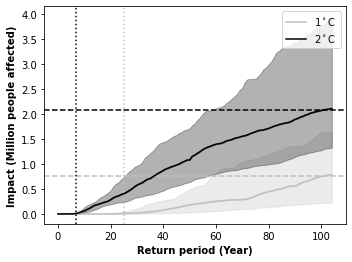

In [69]:

import copy
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
ylabel = {"assets":"Impact (Billion USD)","pop":"Impact (Million people affected)"}
country = '704'
plt.rcParams['axes.labelweight'] = 'bold'

fq = all_countries_impacts[country]['1']['pop']['RF'].calc_freq_curve(return_per=np.arange(1,105))
def make_fq_list(impact, factor):
    fq_list = []
    for n in range(1000):
        imp_sample = order_events_by_indices(impact, shuffle(np.arange(len(impact.event_name)))[0:500])
        fq = imp_sample.calc_freq_curve(np.arange(0,105))
        fq_list.append(fq.impact/factor)
    return fq_list, fq.return_per

def plot_return_period_samples(fq_list, return_per, ax, color, label, range=True, linestyle="solid", linewidth=1.5):
    ax.plot(fq.return_per,np.median(fq_list,axis=0), color=color, label=label, linestyle=linestyle,linewidth=linewidth)
    ax.legend()
    if range:
        ax.fill_between(fq.return_per,np.median(fq_list,axis=0),np.percentile(fq_list,q=95,axis=0), color=color, alpha=0.3)
        ax.fill_between(fq.return_per,np.percentile(fq_list,q=5,axis=0), np.median(fq_list,axis=0),color=color, alpha=0.3)
    return ax

factor_dict = {"assets":1e9, "pop":1e6}

fig,ax = plt.subplots(figsize=(5.4,4))
fq_list_dict = {}
colors = {"1":"silver","2":"black"}
for exposure in ["pop"]:
    for period in ["1", "2"]:
        #yearsets_sum = copy.deepcopy(impacts_yearsets[period][exposure]['RF'])
        #yearsets_sum.at_event = impacts_yearsets[period][exposure]['RF'].at_event + shuffle(impacts_yearsets[period][exposure]['TC'].at_event)
        fq_list_rf, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['RF'], factor=factor_dict[exposure])
        fq_list_tc, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['TC'], factor=factor_dict[exposure])
        fq_list_dict[period], fq.return_per =  make_fq_list(combined_impacts[country][period][exposure], factor=factor_dict[exposure])

        
        ax = plot_return_period_samples(fq_list_dict[period], fq.return_per, ax, color=colors[period], label="".join([period,"$^\circ$C"]), range=True)
#        # plot_return_period_samples(fq_list, fq.return_per, ax, color="black", linestyle='dashed', label="Aggregated", range=True, linewidth=0.5)

#         plot_return_period_samples(fq_list_rf, fq.return_per, ax, color="Blue", label="RF risk", range=True)

#         plot_return_period_samples(fq_list_tc, fq.return_per, ax, color="Red", label="TC risk", range=True)

        ax.set_xlabel("Return period (Year)")
        ax.set_ylabel(ylabel[exposure])
        #ax.set_title("People affected with the same year by HW,TC and RF " + period)
        
        med = np.median(fq_list_dict[period], axis=0)
        hor = med[fq.return_per>99.9][0]
        ax.axhline(y=hor, color=colors[period], linestyle='--')
        #ax.text(ax.get_xlim()[1] * 0.9, hor, '100-yr impact ' + period + '$^\circ$C', color="red", ha='right', va='bottom')  # Description for the horizontal line
        print(hor)
        vert = fq.return_per[med > 0.01][0]
        ax.axvline(x=vert, color=colors[period], linestyle=':')
        print(vert)
        # ax.text(vert, ax.get_ylim()[1] * 0.9, 'onset ' + period + '$^\circ$C', color="red", ha='right', rotation='vertical')  # Description for the vertical line

                            # Description for the horizontal line
plt.savefig("fig6b.pdf", bbox_inches='tight')


In [36]:
med = np.median(fq_list_dict[period], axis=0)
fq.return_per[med>0.01]

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104])

In [48]:
1e6/100e6

0.01

In [14]:
at_event = combined_impacts[country][warming][exposure].at_event[np.where(combined_impacts[country][warming][exposure].at_event>3.2)[0]]

In [56]:
np.sort(at_event)

array([4.05345140e+00, 4.05345140e+00, 4.05345140e+00, ...,
       1.43171551e+07, 1.56208000e+07, 1.56208000e+07])

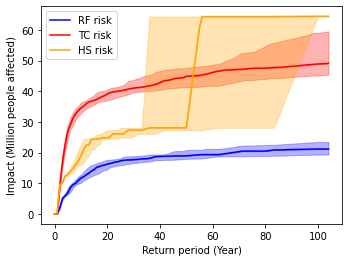

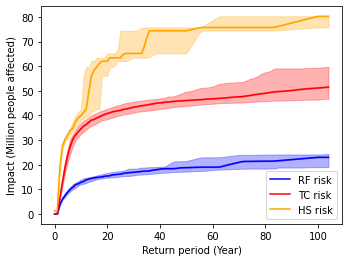

In [15]:
import copy
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
ylabel = {"assets":"Impact (Billion USD)","pop":"Impact (Million people affected)"}
country = '704'

def make_fq_list(impact, factor):
    fq_list = []
    for n in range(1000):
        imp_sample = order_events_by_indices(impact, shuffle(np.arange(len(impact.event_name)))[0:500])
        fq = imp_sample.calc_freq_curve(np.arange(0,105))
        fq_list.append(fq.impact/factor)
    return fq_list, fq.return_per

def plot_return_period_samples(fq_list, return_per, ax, color, label, range=True, linestyle="solid", linewidth=1.5):
    ax.plot(fq.return_per,np.median(fq_list,axis=0), color=color, label=label, linestyle=linestyle,linewidth=linewidth)
    ax.legend()
    if range:
        ax.fill_between(fq.return_per,np.median(fq_list,axis=0),np.percentile(fq_list,q=95,axis=0), color=color, alpha=0.3)
        ax.fill_between(fq.return_per,np.percentile(fq_list,q=5,axis=0), np.median(fq_list,axis=0),color=color, alpha=0.3)
    return ax

factor_dict = {"assets":1e9, "pop":1e6}

for exposure in ["pop"]:
    for period in ["1", "2"]:
        #yearsets_sum = copy.deepcopy(impacts_yearsets[period][exposure]['RF'])
        #yearsets_sum.at_event = impacts_yearsets[period][exposure]['RF'].at_event + shuffle(impacts_yearsets[period][exposure]['TC'].at_event)
        fig,ax = plt.subplots(figsize=(5.4,4))
        fq_list_rf, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['RF'], factor=factor_dict[exposure])
        fq_list_tc, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['TC'], factor=factor_dict[exposure])
        fq_list_hw, fq.return_per =  make_fq_list(all_countries_impacts[country][period][exposure]['HS'], factor=factor_dict[exposure])

        fq_list, fq.return_per =  make_fq_list(combined_impacts[country][period][exposure], factor=factor_dict[exposure])

        
#        plot_return_period_samples(fq_list, fq.return_per, ax, color="Purple", label="Spatially compounding risk", range=True)

#        # plot_return_period_samples(fq_list, fq.return_per, ax, color="black", linestyle='dashed', label="Aggregated", range=True, linewidth=0.5)

        plot_return_period_samples(fq_list_rf, fq.return_per, ax, color="Blue", label="RF risk", range=True)
        plot_return_period_samples(fq_list_tc, fq.return_per, ax, color="Red", label="TC risk", range=True)
        plot_return_period_samples(fq_list_hw, fq.return_per, ax, color="Orange", label="HS risk", range=True)


        ax.set_xlabel("Return period (Year)")
        ax.set_ylabel(ylabel[exposure])

        #plt.savefig("".join(['/Users/szelie/Dropbox/Applications/Overleaf/multi_risk_scientific_report/figures/return_periods_aggr_1degree_',exposure,".jpg"]), dpi=1200, bbox_inches='tight')
        plt.savefig("".join([f"rp_single_risk_vietnam_{warming}.jpg"]), dpi=1200, bbox_inches='tight')


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Define colors
colors = {
    'TC': 'red',
    'RF': 'blue',
    'HS': 'orange',
    ('TC', 'RF'): 'purple',
    ('TC', 'HS'): 'sienna',
    ('RF', 'HS'): 'orangered'
}

plt.rcParams.update({'font.size': 20})

for warming in ["1", "2"]:
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))

    # Assuming n=0 for the first plot
    n = 0
    condition = combined_impacts[country][warming][exposure].at_event >= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>98][0]*1e6)
    condition2 = combined_impacts[country][warming][exposure].at_event <= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>102][0]*1e6)
    event = combined_impacts[country][warming][exposure].event_id[np.where(condition&condition2)[0][n]]

    ax.set_aspect('equal')

    # Load world map and plot Vietnam's border
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    vietnam = world[world['name'] == 'Vietnam']
    vietnam.boundary.plot(color='darkgrey', ax=ax, linewidth=1)
    ctx.add_basemap(ax, crs=vietnam.crs)

    # Plotting code for each hazard type
    # ... (rest of your plotting code) ...

    plt.tight_layout(pad=0.01)
    plt.savefig(f"maps_return_periods_100y_{warming}.jpg", bbox_inches='tight', dpi=800)


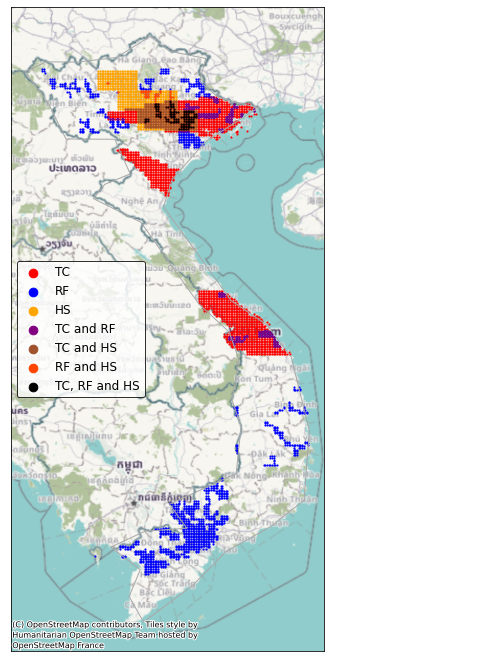

In [45]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import colors
import contextily as ctx
import warnings

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12

warnings.filterwarnings('ignore')
colors = {
    'TC': 'red',
    'RF': 'blue',
    'HS': 'orange',
    ('TC', 'RF'): 'purple',
    ('TC', 'HS'): 'sienna',  # Choose a color for TC & HW combination
    ('RF', 'HS'): 'orangered'     # Choose a color for RF & HW combination
}
num_plots=1
plt.rcParams.update({'font.size': 12})  # You can change 12 to your desired size

for warming in ["1"]:
    fig, axes = plt.subplots(1, 1, figsize=(18, 9))

    for n in np.arange(0,num_plots):
        condition = combined_impacts[country][warming][exposure].at_event >= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>99][0]*1e6)
        condition2 = combined_impacts[country][warming][exposure].at_event <= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>102][0]*1e6)
        event = combined_impacts[country][warming][exposure].event_id[np.where(condition&condition2)[0][n]]

        ax = axes
        ax.set_aspect('equal')
        # Load world map
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Extract Vietnam's border
        vietnam = world[world['name'] == 'Vietnam']

        # Plot the world map and Vietnam's border
        vietnam.boundary.plot(color='darkgrey', ax=ax, linewidth=1)

        ctx.add_basemap(ax, crs=vietnam.crs)

        #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        #world.plot(color='whitesmoke', ax=ax)
        #world.boundary.plot(color='lightgrey', ax=ax, linewidth=0.1)

        for hazard in all_countries_impacts[country][warming]['pop']:
            all_countries_impacts[country][warming]['pop'][hazard].event_id = np.arange(0, len(all_countries_impacts[country][warming]['pop'][hazard].event_id))
            gdf = all_countries_impacts[country][warming]['pop'][hazard]._build_exp_event(event).gdf
            #gdf.merge(world)
            gdf=gdf[gdf.value>1]
            gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
            #gdf.crs = gdf.set_crs(epsg=4326)    
            gdf.plot('value', ax=ax, markersize=5,marker='.', label=hazard, color=colors[hazard],vmin=0.1)

        for combination in combined_impacts_pairs[country][warming]['pop']:
            gdf = combined_impacts_pairs[country][warming]['pop'][combination]._build_exp_event(event).gdf
            #gdf.merge(world)
            gdf=gdf[gdf.value>1]
            gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
            #gdf.crs = gdf.set_crs(epsg=4326)
            gdf.plot('value', ax=ax, markersize=5,marker='.', label=" and ".join(combination), legend=True, color=colors[combination],vmin=0.1)

        gdf = combined_impacts[country][warming][exposure]._build_exp_event(event).gdf
        #gdf.merge(world)
        gdf=gdf[gdf.value>1]
        gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
        #gdf.crs = gdf.set_crs(epsg=4326)   

        gdf.plot('value', ax=ax, markersize=5,marker='.', label='TC, RF and HS', color='black',vmin=0.1)
        # lgnd = ax.legend(loc="lower left", scatterpoints=1, fontsize=10)
        # lgnd.legendHandles[0]._sizes = [130]
        lgnd = plt.legend(scatterpoints=1, fontsize=12)
        lgnd.get_frame().set_facecolor('white')  # Set the legend background to light grey
        lgnd.get_frame().set_edgecolor('black')  # Set the legend border to black

        for points in lgnd.legendHandles:
            points._sizes = [300]
            points._sizes = [300]
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  
    plt.subplots_adjust(wspace=0.01)
    plt.tight_layout(pad=0.01)
    plt.savefig(f"fig6a.jpg", bbox_inches='tight', dpi=800)
        #print(combined_impacts[country][warming][exposure].at_event[np.where(condition&condition2)[0][n]])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


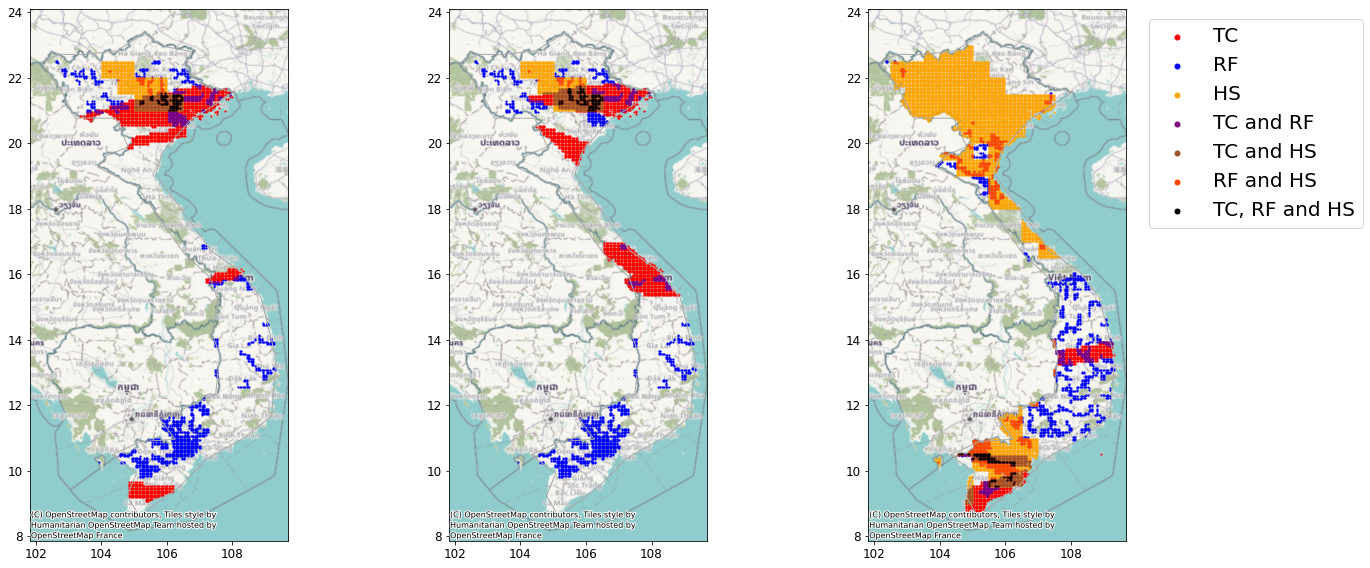

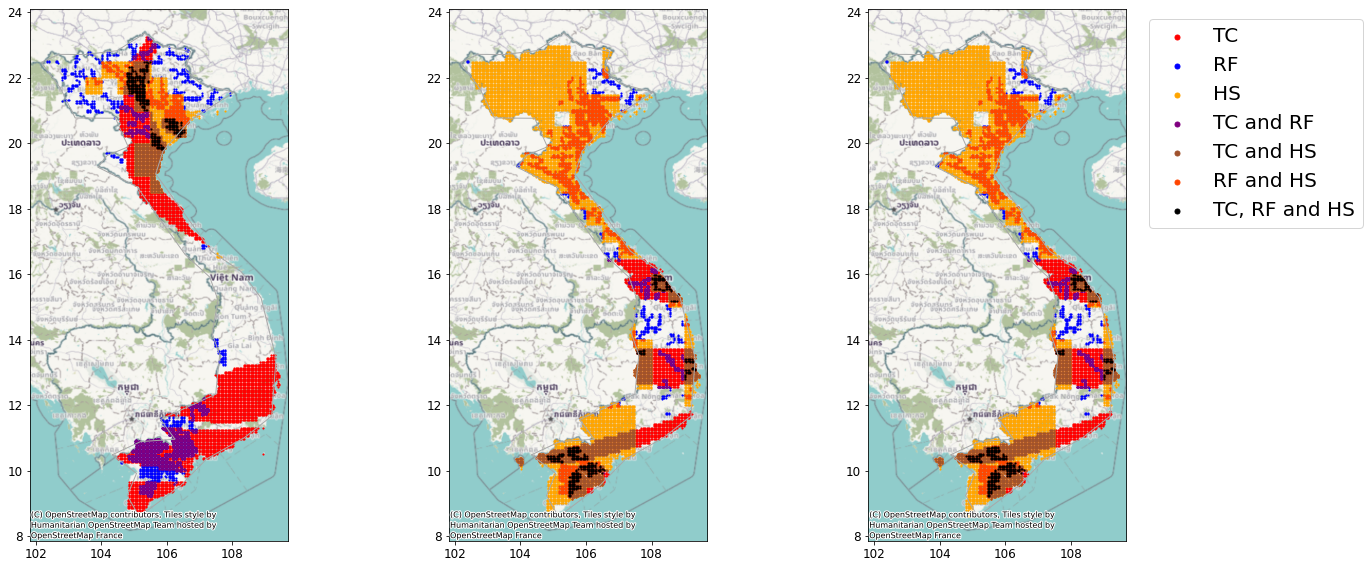

In [50]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import colors
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')
colors = {
    'TC': 'red',
    'RF': 'blue',
    'HS': 'orange',
    ('TC', 'RF'): 'purple',
    ('TC', 'HS'): 'sienna',  # Choose a color for TC & HW combination
    ('RF', 'HS'): 'orangered'     # Choose a color for RF & HW combination
}
num_plots=3

for warming in ["1","2"]:
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 8))

    for n in np.arange(0,num_plots):
        condition = combined_impacts[country][warming][exposure].at_event >= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>98][0]*1e6)
        condition2 = combined_impacts[country][warming][exposure].at_event <= (np.array(np.median(fq_list_dict[warming],axis=0))[fq.return_per>102][0]*1e6)
        event = combined_impacts[country][warming][exposure].event_id[np.where(condition&condition2)[0][n]]

        ax = axes[n]
        ax.set_aspect('equal')
        # Load world map
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Extract Vietnam's border
        vietnam = world[world['name'] == 'Vietnam']

        # Plot the world map and Vietnam's border
        vietnam.boundary.plot(color='darkgrey', ax=ax, linewidth=1)

        ctx.add_basemap(ax, crs=vietnam.crs)

        #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        #world.plot(color='whitesmoke', ax=ax)
        #world.boundary.plot(color='lightgrey', ax=ax, linewidth=0.1)

        for hazard in all_countries_impacts[country][warming]['pop']:
            all_countries_impacts[country][warming]['pop'][hazard].event_id = np.arange(0, len(all_countries_impacts[country][warming]['pop'][hazard].event_id))
            gdf = all_countries_impacts[country][warming]['pop'][hazard]._build_exp_event(event).gdf
            #gdf.merge(world)
            gdf=gdf[gdf.value>1]
            gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
            #gdf.crs = gdf.set_crs(epsg=4326)    
            gdf.plot('value', ax=ax, markersize=5,marker='.', label=hazard, color=colors[hazard],vmin=0.1)

        for combination in combined_impacts_pairs[country][warming]['pop']:
            gdf = combined_impacts_pairs[country][warming]['pop'][combination]._build_exp_event(event).gdf
            #gdf.merge(world)
            gdf=gdf[gdf.value>1]
            gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
            #gdf.crs = gdf.set_crs(epsg=4326)
            gdf.plot('value', ax=ax, markersize=5,marker='.', label=" and ".join(combination), legend=True, color=colors[combination],vmin=0.1)

        gdf = combined_impacts[country][warming][exposure]._build_exp_event(event).gdf
        #gdf.merge(world)
        gdf=gdf[gdf.value>1]
        gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
        #gdf.crs = gdf.set_crs(epsg=4326)   

        gdf.plot('value', ax=ax, markersize=5,marker='.', label='TC, RF and HS', color='black',vmin=0.1)
        # lgnd = ax.legend(loc="lower left", scatterpoints=1, fontsize=10)
        # lgnd.legendHandles[0]._sizes = [130]
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=20,  bbox_to_anchor=(1.05, 1))
        for points in lgnd.legendHandles:
            points._sizes = [100]
            points._sizes = [100]
    plt.subplots_adjust(wspace=0.01)
    plt.tight_layout(pad=0.01)
    plt.savefig(f"maps_return_periods_100y_{warming}.jpg", bbox_inches='tight', dpi=800)
        #print(combined_impacts[country][warming][exposure].at_event[np.where(condition&condition2)[0][n]])


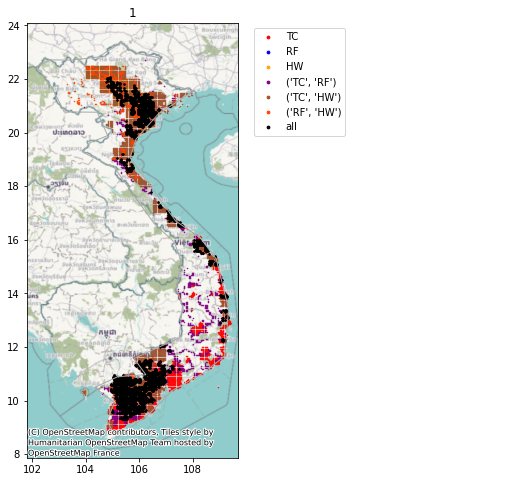

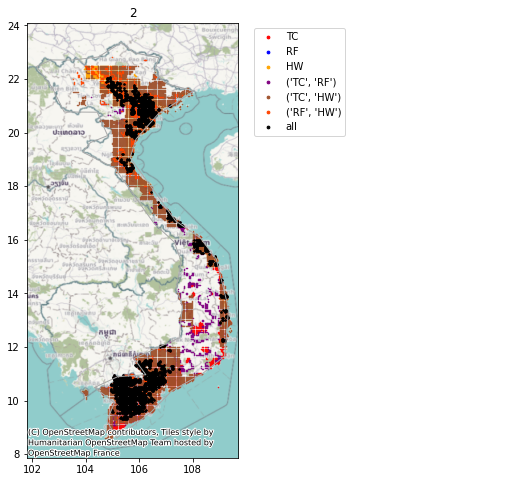

In [151]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import colors
import contextily as ctx

colors = {
    'TC': 'red',
    'RF': 'blue',
    'HW': 'orange',
    ('TC', 'RF'): 'purple',
    ('TC', 'HW'): 'sienna',  # Choose a color for TC & HW combination
    ('RF', 'HW'): 'orangered'     # Choose a color for RF & HW combination
}

for warming in ["1","2"]:
        
    fq = combined_impact.calc_freq_curve()
    condition = combined_impact.at_event > fq.impact[fq.return_per > 100][1]
    event = np.where(condition)[0][n]
    eai_exp = np.squeeze(np.asarray(combined_impact.imp_mat[event,:].todense()))
    combined_impact_100 = combined_impact.select(event_ids=combined_impact.event_id[event])
    combined_impact_100.eai_exp = eai_exp
    event = combined_impact_100.event_id

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Load world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Extract Vietnam's border
    vietnam = world[world['name'] == 'Vietnam']

    # Plot the world map and Vietnam's border
    vietnam.boundary.plot(color='darkgrey', ax=ax, linewidth=1)

    ctx.add_basemap(ax, crs=vietnam.crs)

    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #world.plot(color='whitesmoke', ax=ax)
    #world.boundary.plot(color='lightgrey', ax=ax, linewidth=0.1)

    for hazard in all_countries_impacts[country][warming]['pop']:
        all_countries_impacts[country][warming]['pop'][hazard].event_id = np.arange(0, len(all_countries_impacts[country][warming]['pop'][hazard].event_id))
        gdf = all_countries_impacts[country][warming]['pop'][hazard]._build_exp().gdf
        #gdf.merge(world)
        gdf=gdf[gdf.value>1000]
        gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
        #gdf.crs = gdf.set_crs(epsg=4326)    
        gdf.plot('value', ax=ax, markersize=1,marker='.', label=hazard, legend=True, color=colors[hazard],vmin=1, vmax=1000)

    for combination in combined_impacts_pairs[country][warming]['pop']:
        gdf = combined_impacts_pairs[country][warming]['pop'][combination]._build_exp().gdf
        #gdf.merge(world)
        gdf=gdf[gdf.value>1000]
        gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
        #gdf.crs = gdf.set_crs(epsg=4326)
        gdf.plot('value', ax=ax, markersize=1,marker='.', label=str(combination), legend=True, color=colors[combination],vmin=1, vmax=1000)

    gdf = combined_impact._build_exp().gdf
    #gdf.merge(world)
    gdf=gdf[gdf.value>1000]
    gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
    #gdf.crs = gdf.set_crs(epsg=4326)   

    gdf.plot('value', ax=ax, markersize=10,marker='.', label='all', color='black',vmin=1, vmax=1000)
    # lgnd = ax.legend(loc="lower left", scatterpoints=1, fontsize=10)
    # lgnd.legendHandles[0]._sizes = [130]
    lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10,  bbox_to_anchor=(1.05, 1))
    for points in lgnd.legendHandles:
        points._sizes = [30]
        points._sizes = [30]
        